In [ ]:
from google.colab import drive
drive.mount('content')

In [ ]:
!unzip "/content/content/MyDrive/output (2)"
#!unzip "/content/content/MyDrive/output"

In [ ]:
!unzip "/content/content/MyDrive/detectron2_mask (2)"
#!unzip "/content/content/MyDrive/detectron2_mask"

In [ ]:
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
!pip install pyyaml==5.1

In [ ]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

In [ ]:
import torch
assert torch.__version__.startswith("1.8")
import torchvision
import cv2

In [ ]:
import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog,MetadataCatalog 

In [ ]:
def get_data_dicts(directory,classes):
  dataset_dicts=[]
  idx=0
  for filename in[file for file in os.listdir(directory) if file.endswith('.json')]:
    json_file=os.path.join(directory,filename)
    with open(json_file) as f:
      img_anns =json.load(f)

    record={}

    filename=os.path.join(directory,img_anns["imagePath"])

    record["file_name"]= filename
    record["height"]=1127
    record["width"]=1991
    record["image_id"] = idx
    idx= idx + 1
    annos=img_anns["shapes"]
    objs=[]
    for anno in annos:
        px = [a[0] for a in anno['points']]
        py= [a[1] for a in anno['points']]
        poly=[(x,y) for x,y in zip(px,py)]
        poly=[p for x in poly for p in x]

        obj= {
            "bbox": [np.min(px),np.min(py),np.max(px),np.max(py)],
            "bbox_mode": BoxMode.XYXY_ABS,
            "category_id":classes.index(anno['label']),
            "segmentation":[poly],
            "iscrowd":0
        }

        objs.append(obj)
    record["annotations"]=objs
    dataset_dicts.append(record)
  return dataset_dicts

In [ ]:
classes=['molar','front','hidden','premolar']
data_path='/content/'

for d in ["train","test"]:
  DatasetCatalog.register(
      "my_" +d,
      lambda d=d: get_data_dicts(data_path+d,classes)
  )
  MetadataCatalog.get("my_"+d).set(thing_classes=classes)
microcontroller_metadata = MetadataCatalog.get("my_train")

In [ ]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer,DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import  ColorMode,Visualizer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader 
from matplotlib.patches import Rectangle

In [ ]:
cfg=get_cfg() #config dosyasını oluşturur
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml"))
cfg.DATASETS.TRAIN= ("my_train",) #train verilerini confige kaydetme
cfg.DATASETS.TEST=()
cfg.DATALOADER.NUM_WORKERS= 4
cfg.MODEL.WEIGHTS=model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH=2 #batch size
cfg.SOLVER.BASE_LR=0.001 #learning rate
cfg.SOLVER.GAMMA=0.05 #learning rate çarpanı
cfg.SOLVER.STEPS=[500] # kaç adımda bir gamma uygulansın
cfg.TEST.EVAL_PERIOD=200 #modeli değerlendiremk için adım sayısı

cfg.SOLVER.MAX_ITER=2000 #iterasyon sayısı BUNU 2000 YAPPPP
cfg.MODEL.ROI_HEADS.NUM_CLASSES=4 #sınıf sayısı

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #train moduna geçme 
trainer.resume_or_load(resume=False)

In [ ]:
trainer.train()

In [ ]:
%load_ext tensorboard 
%tensorboard --logdir output

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST=0.5
cfg.DATASETS.TEST=("my_test",)
predictor=DefaultPredictor(cfg)
test_metadata=MetadataCatalog.get("my_test")
test_dataset_dicts=get_data_dicts(data_path+'test',classes)


In [ ]:
for d in random.sample(test_dataset_dicts,4): 
  img=cv2.imread(d["file_name"])
  outputs=predictor(img)
  v=Visualizer(img[:,:,::-1],
               metadata=microcontroller_metadata,
               scale=0.8,

        

  )
  v=v.draw_instance_predictions(outputs["instances"].to("cpu"))
  plt.figure(figsize=(20,10))
  plt.imshow(cv2.cvtColor(v.get_image()[:,:,::-1],cv2.COLOR_BGR2RGB))
  plt.show(_)

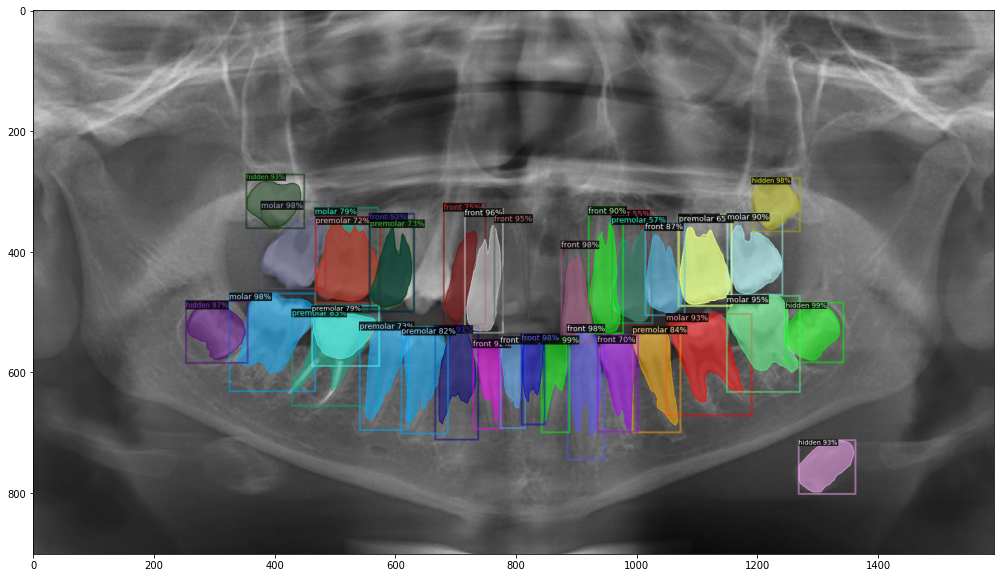

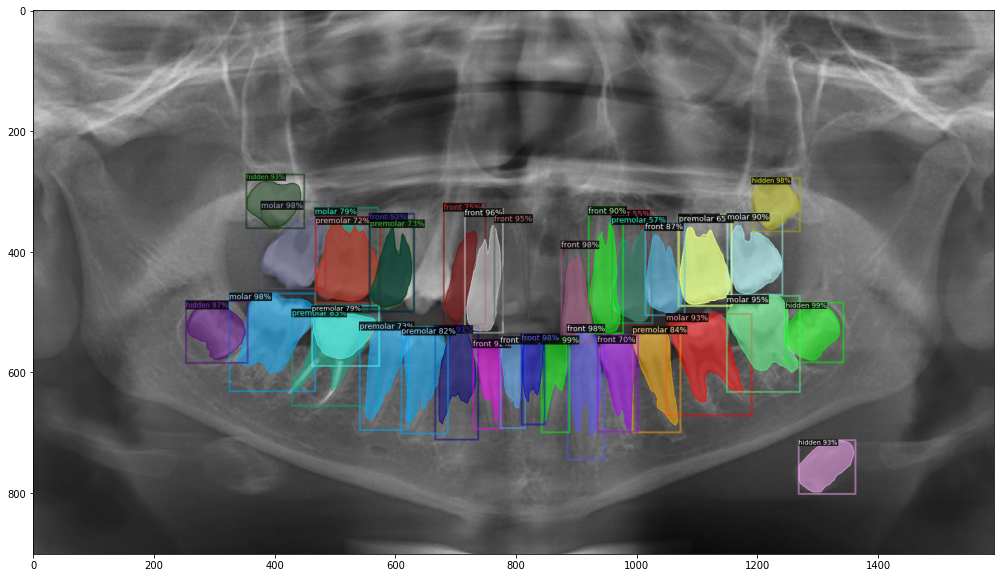

In [ ]:
#import detectron2
from detectron2.utils.visualizer import ColorMode
import glob
from google.colab.patches import cv2_imshow
for imageName in glob.glob('/content/content/MyDrive/disler/150.jpg'): #/content/test/155.jpg /content/content/MyDrive/170.jpg /content/content/MyDrive/disler/1.jpg
  im=cv2.imread(imageName)
  outputs=predictor(im)
  v = Visualizer(im[:,:,::-1],
      metadata=test_metadata,
      scale=0.8
  )
  out=v.draw_instance_predictions(outputs["instances"].to("cpu"))
  plt.figure(figsize=(20,10))
  plt.imshow(cv2.cvtColor(out.get_image()[:,:,::-1],cv2.COLOR_BGR2RGB))
  plt.show(_)

In [ ]:
evaluator=COCOEvaluator("my_test",output_dir="./output")
val_loader=build_detection_test_loader(cfg,"my_test")

In [ ]:
from detectron2.data import build_detection_test_loader
evaluator=COCOEvaluator("my_test",output_dir="./output")
val_loader=build_detection_test_loader(cfg,"my_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator=COCOEvaluator('my_test',cfg,False,output_dir="./output")
val_loader=build_detection_test_loader(cfg,'my_test')
#inference_on_dataset(predictor.model,val_loader,evaluator)
result = inference_on_dataset(predictor.model, val_loader, evaluator)
print(result)

In [ ]:
print(test_dataset_dicts)